In [32]:
# Get the parent directory
import sys
import os
import pandas as pd
import yaml
parent_dir = os.path.dirname(os.path.realpath("."))
sys.path.append(parent_dir)
import seaborn as sns
import pickle

In [33]:
from dreamsim import dreamsim
from PIL import Image
import torch

device = "cuda"
model, preprocess = dreamsim(pretrained=True, device=device)

Using cached ./models


Using cache found in ./models/facebookresearch_dino_main


In [34]:
!ls /workspace/Diploma/OneActor/experiments/teenager_wearing_shorts_and_canvas_shoes/exp_2504141904

base			output_2504151603  reconciliation
config_2504141904.yaml	output_2504151631  reconciliation.ipynb
metric_ds.pickle	output_2504151724  target.jpg
output_2504151206	output_2504151752  target_mask.png
output_2504151233	output_2504152002  xt_list.pkl


In [35]:
exp_dirs = [
'/workspace/Diploma/OneActor/experiments/adventurer_with_tousled_hair_comic_book/exp_2504141913',
'/workspace/Diploma/OneActor/experiments/young_woman_with_long_wavy_hair/exp_2504141856',
'/workspace/Diploma/OneActor/experiments/teenager_wearing_shorts_and_canvas_shoes/exp_2504141904',
'/workspace/Diploma/OneActor/experiments/unicorn_with_a_coat/exp_2504192159']

In [36]:
res = []
for exp_dir in exp_dirs:
    target_path = f"{exp_dir}/target.jpg"
    for _, dir, _ in os.walk(exp_dir):
        break
    dir = [d for d in dir if 'output' in d]
    for d in dir:
        with open(f"{exp_dir}/{d}/log_train.log", 'r') as config_file:
            config = yaml.safe_load(config_file)
        for _, _, files in os.walk(f"{exp_dir}/{d}/inference"):
            break
        for f in files:
            res.append({
                'thema': exp_dir.split("/")[5],
                'exp': exp_dir.split("/")[6],
                'model': d,
                'config': config,
                'target_img_path': target_path,
                'gen_img_path': f"{exp_dir}/{d}/inference/{f}",
                'prompt':('_'.join(f.split(".")[0].split("_")[:-1])),
                'epoch':0 if f.split(".")[0].split("_")[-1] == 'sdxl' else int(f.split(".")[0].split("_")[-1])
            })

In [37]:
from torchmetrics.multimodal.clip_score import CLIPScore
import torch
metric = CLIPScore(model_name_or_path="openai/clip-vit-base-patch16")

In [43]:
metric = metric.to(device)

In [46]:
import numpy as np
from tqdm import tqdm
for n, r in tqdm(enumerate(res)):
    img1 = Image.open(r['target_img_path'])
    img2 = Image.open(r['gen_img_path'])
    img1 = np.array(img1.convert("RGB"))
    img1 = torch.from_numpy(img1).permute(2, 0, 1).to(device)
    img2 = np.array(img2.convert("RGB"))
    img2 = torch.from_numpy(img2).permute(2, 0, 1).to(device)
    clip_score = metric(img1, img2)
    res[n]['CLIPScore'] = clip_score.detach().round().item()

590it [00:58, 10.17it/s]


In [47]:
for n, r in enumerate(res):
    img1 = preprocess(Image.open(r['target_img_path'])).to(device)
    img2 = preprocess(Image.open(r['gen_img_path'])).to(device)
    distance = model(img1, img2)
    res[n]['dreamsim'] = float(distance.cpu().detach().numpy()[0])

In [48]:
for n, r in enumerate(res):
    if r['config']['use_mask']:
        title = f"mask, p={r['config']['mask_power']}, a={r['config']['mask_alpha']}"
    elif r['config']['use_zone']:
        title = f"zone, a={r['config']['zone_alpha']}"
    else:
        title="OneActor"
    res[n]['title'] = title

In [53]:
df = pd.DataFrame(res)
df = df[['thema', 'exp', 'model', 'prompt',
       'epoch', 'dreamsim', 'title', 'CLIPScore']]
df[df['epoch'] == 100].groupby(['title']).agg({'dreamsim':'mean', 'exp':'count'})

,dreamsim,exp
title,,
OneActor,0.359672,22
"mask, p=0.5, a=0.5",0.337110,22
"mask, p=1.0, a=0.25",0.356664,14
"mask, p=1.0, a=0.5",0.350334,18
"mask, p=2.0, a=0.5",0.356616,14
"zone, a=0.25",0.340573,14
"zone, a=0.5",0.354290,14


In [55]:
df_agg=df.groupby(['epoch', 'title']).agg({'dreamsim':'mean', 'exp':'count'}).reset_index()

<Axes: xlabel='epoch', ylabel='dreamsim'>

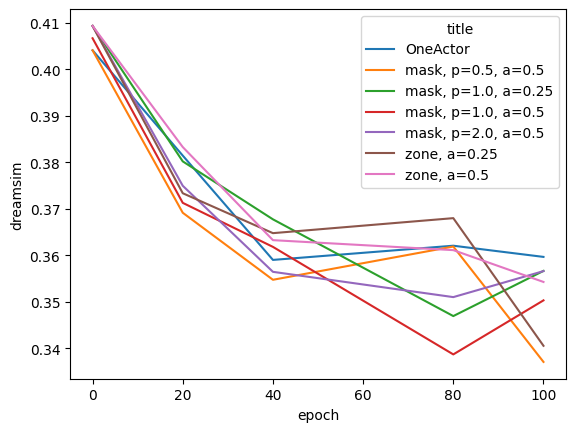

In [56]:
sns.lineplot(data=df_agg, x="epoch", y="dreamsim", hue="title")

([0, 1, 2, 3, 4, 5, 6],
 [Text(0, 0, 'zone, a=0.25'),
  Text(1, 0, 'mask, p=1.0, a=0.25'),
  Text(2, 0, 'mask, p=2.0, a=0.5'),
  Text(3, 0, 'mask, p=0.5, a=0.5'),
  Text(4, 0, 'zone, a=0.5'),
  Text(5, 0, 'mask, p=1.0, a=0.5'),
  Text(6, 0, 'OneActor')])

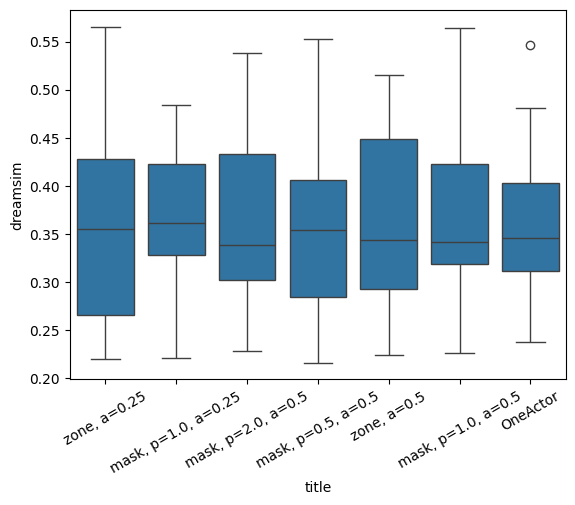

In [57]:
from matplotlib import pyplot as plt
sns.boxplot(data=df[df['epoch'] == 40], x="title", y="dreamsim")
plt.xticks(rotation=30)

In [58]:
df = df.merge(df[df['title'] == "OneActor"][['thema', 'prompt', 'epoch', 'dreamsim']].rename(columns={'dreamsim':'OA_distance'}), on=['thema', 'prompt', 'epoch'])

In [59]:
df['diff'] = df['OA_distance'] - df['dreamsim']

In [60]:
df[(df['epoch'] == 100)].sort_values('diff', ascending=False)

,thema,exp,model,prompt,epoch,dreamsim,title,CLIPScore,OA_distance,diff
625,teenager_wearing_shorts_and_canvas_shoes,exp_2504141904,output_2504151631,the_effel_tower_as_a_background_step,100,0.322569,"mask, p=0.5, a=0.5",77.0,0.439687,0.117118
275,young_woman_with_long_wavy_hair,exp_2504141856,output_2504151019,walking_on_sunset_beach_step,100,0.438066,"zone, a=0.25",76.0,0.549476,0.111410
620,teenager_wearing_shorts_and_canvas_shoes,exp_2504141904,output_2504151631,the_statue_of_liberty_as_a_background_step,100,0.467657,"mask, p=0.5, a=0.5",71.0,0.559450,0.091793
605,teenager_wearing_shorts_and_canvas_shoes,exp_2504141904,output_2504151724,a_city_as_background_step,100,0.266081,"mask, p=2.0, a=0.5",86.0,0.353627,0.087546
550,teenager_wearing_shorts_and_canvas_shoes,exp_2504141904,output_2504152002,the_effel_tower_as_a_background_step,100,0.356058,"zone, a=0.25",74.0,0.439687,0.083629
...,...,...,...,...,...,...,...,...,...,...
236,young_woman_with_long_wavy_hair,exp_2504141856,output_2504201403,walking_on_sunset_beach_step,100,0.552160,"mask, p=0.5, a=0.5",73.0,0.502942,-0.049219
105,adventurer_with_tousled_hair_comic_book,exp_2504141913,output_2504151343,eating_a_burger_step,100,0.433534,"zone, a=0.5",67.0,0.381937,-0.051597
640,teenager_wearing_shorts_and_canvas_shoes,exp_2504141904,output_2504151603,eating_a_burger_step,100,0.401124,"zone, a=0.5",69.0,0.346372,-0.054753
176,young_woman_with_long_wavy_hair,exp_2504141856,output_2504201442,leaning_on_a_fence_step,100,0.276839,OneActor,83.0,0.221763,-0.055076


In [64]:
for exp_dir in exp_dirs:
    with open(f"{exp_dir}/metric_ds.pickle", 'wb') as handle:
        pickle.dump(df[
                    (df['thema'] == exp_dir.split("/")[5]) & (df['exp'] == exp_dir.split("/")[6])
                    ], handle)

In [65]:
with open(f"metric_ds.pickle", 'wb') as handle:
    pickle.dump(df, handle)

In [63]:
! cp ./ds_metrics.ipynb /workspace/Diploma/notebooks